# Preprocessing and Modeling CTR Prediction

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading Dataset and New Time Features

In [2]:
# Reading file (train_shuffled_with_columns.csv is result of shuffling the original train.csv file)
dataset = r'train_shuffled.csv' 
df = pd.read_csv(dataset,nrows=1000000)

# Rename column 'hour' to 'timestamp'
df.rename(columns={'hour':'timestamp'}, inplace=True)

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d%H')

# Sorting rows per 'hour'
df = df.sort_values(by='timestamp')
df.head(2)

,id,click,timestamp,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
325876,15348754204581273148,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15705,320,50,1722,0,35,-1,79
876704,8920252239684887372,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32


In [3]:
# Time sin and cos

# Extract the hour of the day from the timestamp
df['hour'] = df['timestamp'].dt.hour

# Convert hours to radians (since there are 24 hours in a day)
df['radians'] = (df['hour'] / 24) * 2 * np.pi

# Apply sine and cosine transformations
df['sin_time'] = np.sin(df['radians'])
df['cos_time'] = np.cos(df['radians'])

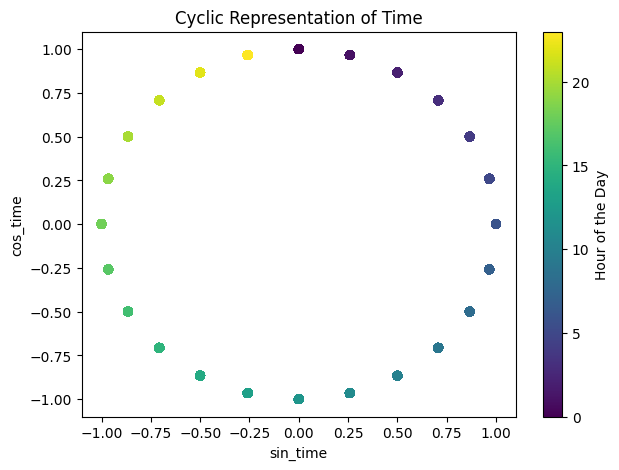

In [14]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
scatter_plot = ax.scatter(df['sin_time'], df['cos_time'], c=df['hour'], cmap='viridis')
ax.set_xlabel('sin_time')
ax.set_ylabel('cos_time')
ax.set_title('Cyclic Representation of Time')
fig.colorbar(scatter_plot, label='Hour of the Day')

plt.show()

In [21]:
# Creating new features

df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d') # yyyy-mm-dd

# num_impressions_user_day: Number of impressions a user (device_id) has in a day
df['num_impressions_user_day'] = df.groupby(['date', 'device_id'])['id'].transform('count')

# time_interval_last_visit: Time interval from the last visit
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['device_id', 'timestamp'], inplace=True)
df['time_interval_last_visit'] = df.groupby('device_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# num_days_user_appears: Number of days the user appeared
df['num_days_user_appears'] = df.groupby('device_id')['date'].transform('nunique')

# num_previous_clicks: number of clicks the user has done 
df['num_previous_clicks'] = df.groupby('device_id')['click'].cumsum() - df['click']

print('new features created')

new features created


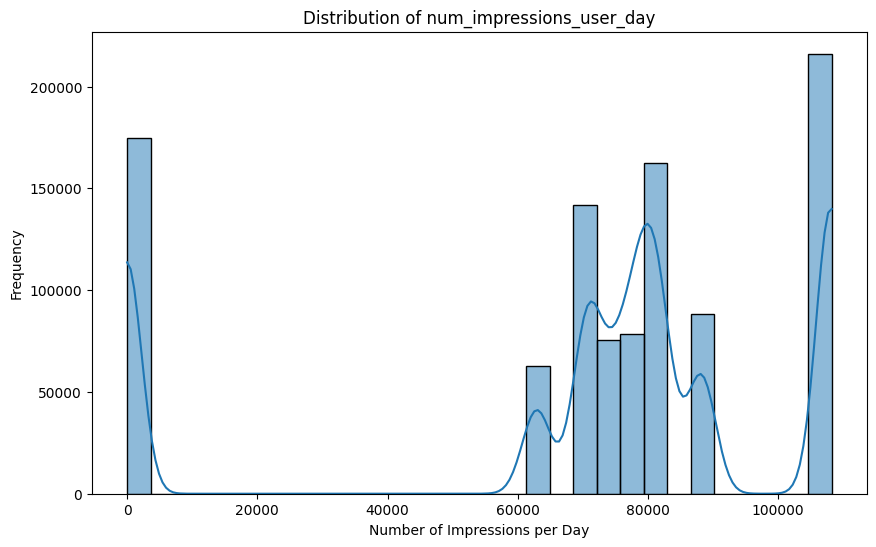

In [22]:
# Plot num_impressions_user_day distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(df['num_impressions_user_day'], bins=30, kde=True)

# Add titles and labels
plt.title('Distribution of num_impressions_user_day')
plt.xlabel('Number of Impressions per Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()


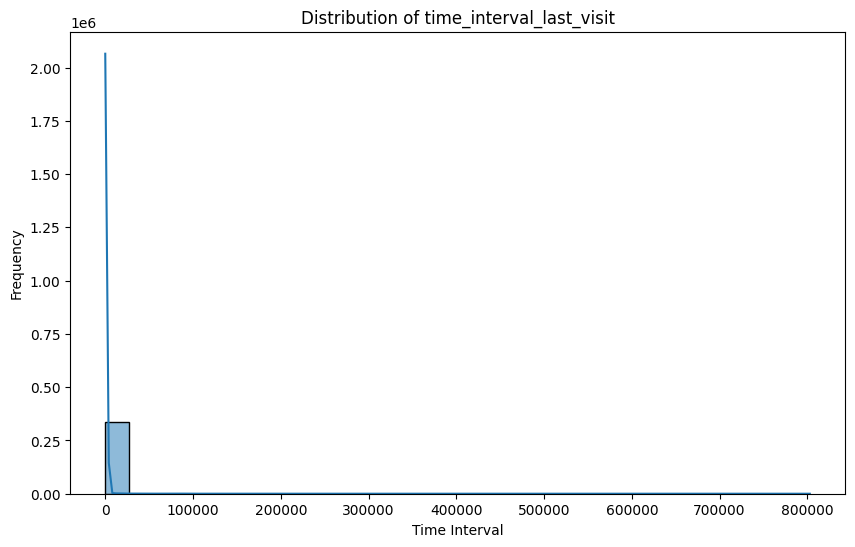

In [11]:
# Plot time_interval_last_visit distribution
# Set the plot size
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(df['time_interval_last_visit'], bins=30, kde=True)

# Add titles and labels
plt.title('Distribution of time_interval_last_visit')
plt.xlabel('Time Interval')
plt.ylabel('Frequency')

# Show the plot
plt.show()

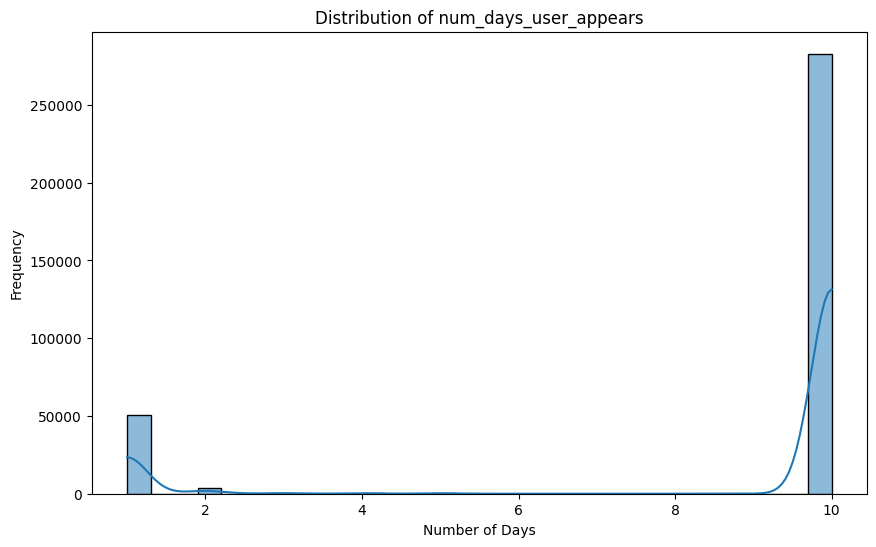

In [12]:
# Plot num_days_user_appears distribution
# Set the plot size
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(df['num_days_user_appears'], bins=30, kde=True)

# Add titles and labels
plt.title('Distribution of num_days_user_appears')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')

# Show the plot
plt.show()

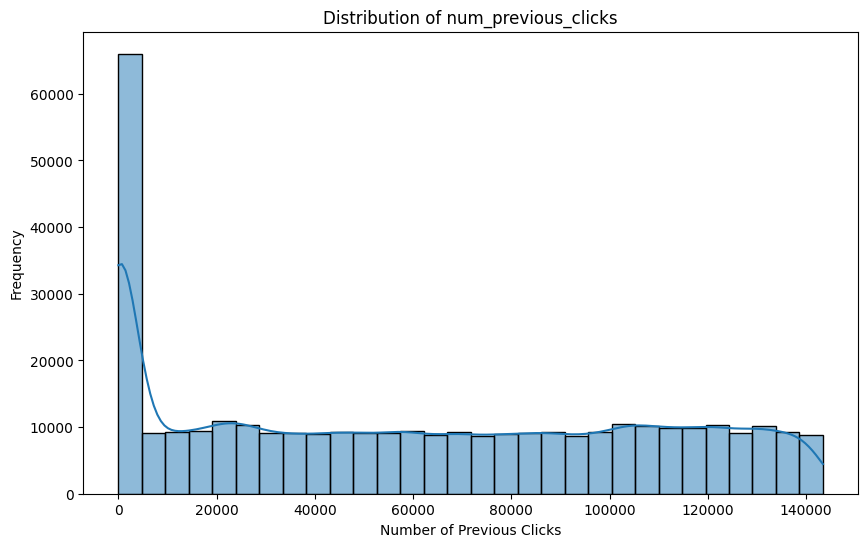

In [13]:
# Plot num_previous_clicks distribution
# Set the plot size
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(df['num_previous_clicks'], bins=30, kde=True)

# Add titles and labels
plt.title('Distribution of num_previous_clicks')
plt.xlabel('Number of Previous Clicks')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [23]:
# Dropping columns 'id' and 'timestamp'
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
    print('column id was deleted')

if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)
    print('column timestamp was deleted')

if 'radians' in df.columns:
    df.drop(columns=['radians'], inplace=True)
    print('column radians was deleted')

if 'hour' in df.columns:
    df.drop(columns=['hour'], inplace=True)
    print('column hour was deleted')

if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)
    print('column date was deleted')

column id was deleted
column timestamp was deleted
column radians was deleted
column hour was deleted
column date was deleted


# Imbalance click

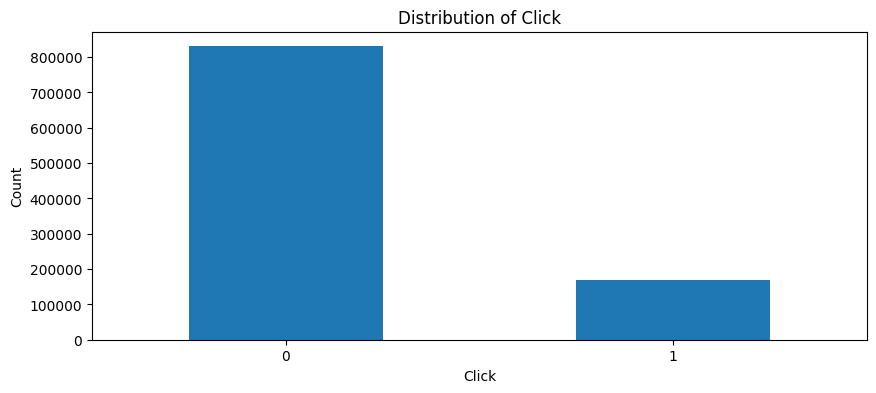

click
0    830446
1    169554
Name: count, dtype: int64
Imbalance ratio: 4.90
Click through rate all dataset: 0.17


In [24]:
# Plotting the distribution of click 

plt.figure(figsize=(10, 4))
df['click'].value_counts().plot(kind='bar')  
plt.xlabel('Click')
plt.ylabel('Count')
plt.title(f'Distribution of Click - Imbalanced')
plt.xticks(rotation=0)  # Rotate x labels by 0 degrees
plt.show()

# Examine imbalance in the target variable 'click'
print(df['click'].value_counts())
imbalance_ratio = df['click'].value_counts()[0] / df['click'].value_counts()[1]
print(f'Imbalance ratio: {imbalance_ratio:.2f}')

# Click thorugh rate
CTR = df['click'].mean()
print(f'Click through rate all dataset: {CTR:.2f}')

# Adressing imbalance problem: Downsampling majority class = 0

In [25]:
# Separate majority and minority classes
df_majority = df[df['click'] == 0]
df_minority = df[df['click'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the DataFrame
df = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class counts
print(df['click'].value_counts())

click
1    169554
0    169554
Name: count, dtype: int64


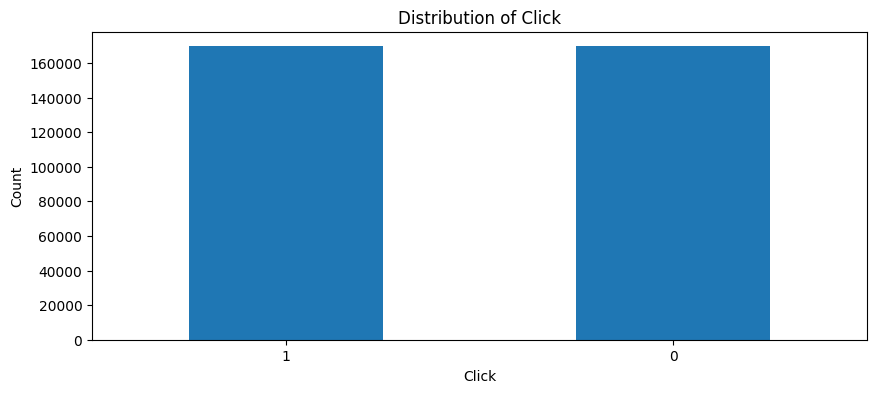

click
1    169554
0    169554
Name: count, dtype: int64
Imbalance ratio: 1.00
Click through rate all dataset: 0.50


In [26]:
# Plotting the new distribution of click 

plt.figure(figsize=(10, 4))
df['click'].value_counts().plot(kind='bar')  
plt.xlabel('Click')
plt.ylabel('Count')
plt.title(f'Distribution of Click')
plt.xticks(rotation=0)  # Rotate x labels by 0 degrees
plt.show()

# Examine imbalance in the target variable 'click'
print(df['click'].value_counts())
imbalance_ratio = df['click'].value_counts()[0] / df['click'].value_counts()[1]
print(f'Imbalance ratio: {imbalance_ratio:.2f}')

# Click thorugh rate
CTR = df['click'].mean()
print(f'Click through rate all dataset: {CTR:.2f}')

In [7]:
df.shape

(339108, 28)

In [8]:
# Summary of Number of unique values and data type per column
summary = pd.DataFrame(df.nunique(), columns=['num_unique'])
summary['dtype'] = df.dtypes
summary

,num_unique,dtype
click,2,int64
C1,7,int64
banner_pos,7,int64
site_id,2065,object
site_domain,2060,object
site_category,20,object
app_id,2089,object
app_domain,146,object
app_category,22,object
device_id,52611,object


In [27]:
variable_types = {
    'click': 'target',
    'C1': 'categorical nominal to encode',
    'banner_pos': 'categorical ready to use',
    'site_id': 'categorical nominal to encode',
    'site_domain': 'categorical nominal to encode',
    'site_category': 'categorical nominal to encode',
    'app_id': 'categorical nominal to encode',
    'app_domain': 'categorical nominal to encode',
    'app_category': 'categorical nominal to encode',
    'device_id': 'categorical nominal to encode',
    'device_ip': 'categorical nominal to encode',
    'device_model': 'categorical nominal to encode',
    'device_type': 'categorical ready to use',
    'device_conn_type': 'categorical ready to use',
    'C14': 'categorical nominal to encode',
    'C15': 'categorical ready to use',
    'C16': 'categorical ready to use',
    'C17': 'categorical ready to use',
    'C18': 'categorical ready to use',
    'C19': 'categorical ready to use',
    'C20': 'categorical nominal to encode', # Most popular label is '-1' and the others have a format like this '100098'
    'C21': 'categorical ready to use',
    'num_impressions_user_day': 'numerical',
    'time_interval_last_visit': 'numerical',
    'num_days_user_appears': 'numerical',
    'num_previous_clicks': 'numerical',
    'sin_time': 'numerical',
    'cos_time': 'numerical'
}

In [28]:
def check_repeated_counts(counts_dict):
    """
    Function to check for repeated count values in a counts dictionary.
    
    Args:
    counts_dict (dict): A dictionary where the keys are the categories and the values are the counts.
    
    Returns:
    bool: True if there are repeated counts, False otherwise.
    """
    unique_counts = set(counts_dict.values())
    return len(unique_counts) != len(counts_dict)

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

def power_of_2(x):
    if x > 6000:
        return (2 ** (int(np.log2(x)) - 13))
    elif x > 500:
        return (2 ** (int(np.log2(x)) - 5))
    elif x > 100:
        return (2 ** (int(np.log2(x)) - 2))
    else:
        return (2 ** (int(np.log2(x))))


def encode_categorical_column(column, column_type, n_features=None):
    """
    Encode a single categorical column based on its type.

    Args:
    column (Series): The Series containing the categorical data.
    column_type (str): The type of the column.
    n_features (int, optional): The number of features for feature hashing.

    Returns:
    Series: The encoded categorical column.
    """
    encoded_column = column.copy()
    
    if column_type == 'categorical ordinal to encode':
        # Apply label encoding
        label_encoder = LabelEncoder()
        encoded_column = label_encoder.fit_transform(encoded_column)
        print(f"Column {column.name} has been encoded with method: Label encoding")
    elif column_type == 'categorical nominal to encode':
        # Check for repeated counts
        counts_dict = column.value_counts().to_dict()
        repeated_counts = check_repeated_counts(counts_dict)
        if not repeated_counts:
            # Apply count frequency encoding
            encoded_column = column.map(column.value_counts())
            print(f"Column {column.name} has been encoded with method: Count Encoding")
        else:
            # Apply feature hashing
            if n_features is None:
                # Calculate the nearest power of 2 less than the number of unique values
                n_features = power_of_2(len(column.unique()))
                n_features = int(n_features)  # Convert to integer
                print(f"Column {column.name} will be encoded with method: Feature Hashing with n_features={n_features}")
            # Convert each element in the column to a string and wrap it in a list
            column_strings = column.astype(str).apply(lambda x: [x])
            hasher = FeatureHasher(n_features=n_features, input_type='string')
            hashed_features = hasher.fit_transform(column_strings)
            encoded_column = pd.Series(hashed_features.toarray().tolist())
            print(f"Column {column.name} has been encoded with method: Feature Hashing")
    else:
        raise ValueError("Invalid column type. Must be 'categorical ordinal to encode' or 'categorical nominal to encode'.")
    
    return encoded_column

In [13]:
# Create a new DataFrame to store the encoded columns
df_encoded = pd.DataFrame()

# Iterate over each column in the original DataFrame
for column_name, column_type in variable_types.items():
    # Check if the column needs encoding
    if column_type in ['categorical ordinal to encode', 'categorical nominal to encode']:
        # Encode the column
        encoded_column = encode_categorical_column(df[column_name], column_type)
        # Add the encoded column to the new DataFrame
        df_encoded[column_name] = encoded_column
    else:
        # For non-categorical columns, simply copy them to the new DataFrame
        df_encoded[column_name] = df[column_name]

# Display the encoded DataFrame
print('df was encoded successfully')

Column C1 has been encoded with method: Count Encoding
Column site_id will be encoded with method: Feature Hashing with n_features=64
Column site_id has been encoded with method: Feature Hashing
Column site_domain will be encoded with method: Feature Hashing with n_features=64
Column site_domain has been encoded with method: Feature Hashing
Column site_category has been encoded with method: Count Encoding
Column app_id will be encoded with method: Feature Hashing with n_features=64
Column app_id has been encoded with method: Feature Hashing
Column app_domain will be encoded with method: Feature Hashing with n_features=32
Column app_domain has been encoded with method: Feature Hashing
Column app_category will be encoded with method: Feature Hashing with n_features=16
Column app_category has been encoded with method: Feature Hashing
Column device_id will be encoded with method: Feature Hashing with n_features=4
Column device_id has been encoded with method: Feature Hashing
Column device_

In [14]:
df_encoded.shape

(339108, 28)

### Splitting Features and Target

In [15]:
# Columns encoded with feature hashing and their respective n_features
columns_to_hash = {
    'site_id': 64,
    'site_domain': 64,
    'app_id': 64,
    'app_domain': 32,
    'app_category': 16,
    'device_id': 4,
    'device_ip': 16,
    'device_model': 128,
    'C14': 32,
    'C20': 32
}

# Function to apply feature hashing and one-hot encoding
def flatten_categorical(df, column, n_features):
    # Apply feature hashing
    hashed_features = df[column].apply(lambda x: hash(str(x)) % n_features)
    
    # Convert hashed features into binary columns using one-hot encoding
    one_hot_encoded = pd.get_dummies(hashed_features, prefix=column)
    
    return one_hot_encoded

# Flatten categorical variables using feature hashing and one-hot encoding
flattened_categorical = []
for column, n_features in columns_to_hash.items():
    flattened_categorical.append(flatten_categorical(df_encoded, column, n_features))

# Concatenate flattened categorical variables with the original dataframe
df_encoded_flattened = pd.concat([df_encoded] + flattened_categorical, axis=1)

# Remove original categorical columns
df_encoded_flattened.drop(columns=columns_to_hash.keys(), inplace=True)

# Display the resulting dataframe
print(df_encoded_flattened.head())


   click      C1  banner_pos  site_category  device_type  device_conn_type  \
0      1  311011           0          67258            1                 0   
1      0  311011           1         108536            1                 2   
2      0  311011           1         108536            1                 0   
3      0   20535           0         125688            0                 0   
4      1  311011           0         125688            1                 2   

   C15  C16   C17  C18  ...  C20_18  C20_19  C20_20  C20_21  C20_22  C20_24  \
0  320   50  2512    2  ...   False   False   False   False   False   False   
1  320   50  1991    2  ...   False   False   False   False   False   False   
2  320   50  2526    3  ...   False   False   False   False   False   False   
3  320   50   549    3  ...   False    True   False   False   False   False   
4  320   50  1248    2  ...   False   False   False   False   False   False   

   C20_26  C20_27  C20_29  C20_30  
0   False   False   

In [16]:
# Separate features and target
X = df_encoded_flattened.drop('click', axis=1)  # Features
y = df_encoded_flattened['click']  # Target

# LR-TruncatedSVD

In [17]:
# TruncatedSVD for dimensionality reduction on sparse input
from sklearn.decomposition import TruncatedSVD

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Fit and transform the sparse data
X_svd = svd.fit_transform(X)

# Create a new DataFrame with the principal components
df_svd = pd.DataFrame(data=X_svd, columns=['PC1', 'PC2'])

# Concatenate the principal components DataFrame with the target variable
df_svd['click'] = df_downsampled['click'].values

# Display the first few rows of the TruncatedSVD DataFrame
print(df_svd.head())

             PC1           PC2  click
0  331753.767772  -7731.078883      0
1  345716.875884   -811.427964      0
2  339213.767143  24956.924569      0
3   54671.257576  93077.077903      0
4  319174.887879  83159.022649      0


## Splitting data in training and test (After SVD)

In [19]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y , test_size=0.2, random_state=42)

## Splitting data in training and test (without SVD)

In [20]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=42)

## LG (using features resulting from SVD)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score

# Fit logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_svd, y_train_svd)

# Predict probabilities
y_prob = logreg.predict_proba(X_test_svd)

# Compute log loss
logloss_LR_SVD = log_loss(y_test_svd, y_prob)
print("Log Loss LG-SVD:", logloss_LR_SVD)

# Confusion Matrix
y_pred = logreg.predict(X_test_svd)
cm = confusion_matrix(y_test_svd, y_pred)
print("Confusion Matrix LG-SVD:")
print(cm)

# Compute TPR and FPR
TN_LR_SVD, FP_LR_SVD, FN_LR_SVD, TP_LR_SVD = cm.ravel()
TPR_LR_SVD = TP_LR_SVD / (TP_LR_SVD + FN_LR_SVD)
FPR_LR_SVD = FP_LR_SVD / (FP_LR_SVD + TN_LR_SVD)
print("True Positive Rate (TPR) LG-SVD:", TPR_LR_SVD)
print("False Positive Rate (FPR) LG-SVD:", FPR_LR_SVD)

# Compute F1-Score
f1_LR_SVD = f1_score(y_test, y_pred)
print("F1-Score (LG-SVD):", f1_LR_SVD)

Log Loss LG-SVD: 0.6908358605295701
Confusion Matrix LG-SVD:
[[18331 15580]
 [16109 17802]]
True Positive Rate (TPR) LG-SVD: 0.524962401580608
False Positive Rate (FPR) LG-SVD: 0.459437940491286
F1-Score (LG-SVD): 0.5290892069011636


# Without SVD (LR + Regulatization)

### Standarizing x

In [22]:
#Changed
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, f1_score

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
logreg = LogisticRegression()

# Create a parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],  # Regularization strengths
    'penalty': ['l2'],  # L2 regularization (Ridge)
    'solver': ['liblinear', 'lbfgs']  # Solvers
}

# Create a GridSearchCV object
grid_search_LR_reg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search_LR_reg.fit(X_train_scaled, y_train)

# Best model
best_logreg_LR_reg = grid_search_LR_reg.best_estimator_

# Predict probabilities with the best model
y_prob_LR_reg = best_logreg_LR_reg.predict_proba(X_test_scaled)

# Compute log loss
logloss_LR_reg = log_loss(y_test, y_prob_LR_reg)
print("Log Loss (Best LR-Regularized):", logloss_LR_reg)

# Make predictions to compute confusion matrix
y_pred_LR_reg = best_logreg_LR_reg.predict(X_test_scaled)
cm_LR_reg = confusion_matrix(y_test, y_pred_LR_reg)
print("Confusion Matrix (Best LR-Regularized):")
print(cm_LR_reg)

# Calculate metrics
TN_LR_reg, FP_LR_reg, FN_LR_reg, TP_LR_reg = cm_LR_reg.ravel()
TPR_LR_reg = TP_LR_reg / (TP_LR_reg + FN_LR_reg)
FPR_LR_reg = FP_LR_reg / (FP_LR_reg + TN_LR_reg)
f1_LR_reg = f1_score(y_test, y_pred_LR_reg)

# Output results
print("True Positive Rate (TPR) (Best LR-Regularized):", TPR_LR_reg)
print("False Positive Rate (FPR) (Best LR-Regularized):", FPR_LR_reg)
print("F1-Score (Best LR-Regularized):", f1_LR_reg)
print("Best parameters found:", grid_search_LR_reg.best_params_)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Log Loss (Best LR-Regularized): 0.6202222990886406
Confusion Matrix (Best LR-Regularized):
[[20167 13744]
 [ 9660 24251]]
True Positive Rate (TPR) (Best LR-Regularized): 0.7151366813128484
False Positive Rate (FPR) (Best LR-Regularized): 0.4052962165668957
F1-Score (Best LR-Regularized): 0.6745195115845687
Best parameters found: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


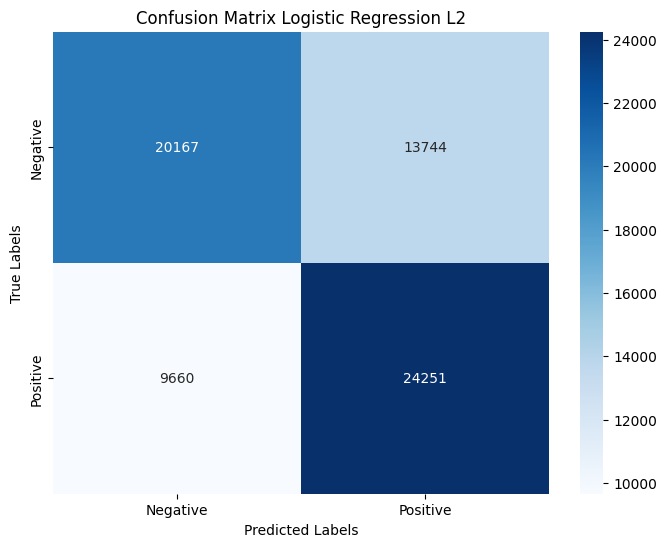

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix data (replace this with your actual cm variable)
TN_LR_reg = 20167
FP_LR_reg = 13744
FN_LR_reg = 9660
TP_LR_reg = 24251

cm = [[TN_LR_reg, FP_LR_reg], [FN_LR_reg, TP_LR_reg]]

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Logistic Regression L2')
plt.show()

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, f1_score

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict probabilities with the best model
y_prob_rf = best_rf.predict_proba(X_test)

# Compute log loss
logloss_rf = log_loss(y_test, y_prob_rf)
print("Log Loss (Random Forest):", logloss_rf)

# Make predictions
y_pred_rf = best_rf.predict(X_test)

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()
TPR_rf = TP_rf / (TP_rf + FN_rf)
FPR_rf = FP_rf / (FP_rf + TN_rf)
print("True Positive Rate (TPR) (Random Forest):", TPR_rf)
print("False Positive Rate (FPR) (Random Forest):", FPR_rf)

# Compute F1-Score
f1_rf = f1_score(y_test, y_pred_rf)
print("F1-Score (Random Forest):", f1_rf)

# Output best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
407 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
203 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python31

Log Loss (Random Forest): 0.5938183679338994
Confusion Matrix (Random Forest):
[[21533 12378]
 [ 9059 24852]]
True Positive Rate (TPR) (Random Forest): 0.7328595441007343
False Positive Rate (FPR) (Random Forest): 0.3650143021438471
F1-Score (Random Forest): 0.6986688407528711
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


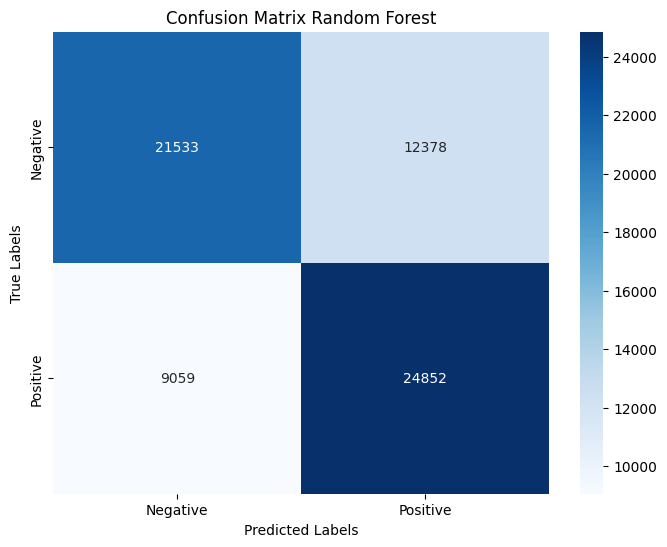

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix data (replace this with your actual cm variable)
TN_rf = 21533
FP_rf = 12378
FN_rf = 9059
TP_rf = 24852

cm = [[TN_rf, FP_rf], [FN_rf, TP_rf]]

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Random Forest')
plt.show()

# XGBoost

In [24]:
# Changed
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, f1_score

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Create a parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # or use more fine-grained values
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create GridSearchCV object
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_

# Predict probabilities
y_prob_xgb = best_xgb.predict_proba(X_test)

# Compute log loss
logloss_xgb = log_loss(y_test, y_prob_xgb)
print("Log Loss (XGBoost):", logloss_xgb)

# Predict labels for confusion matrix
y_pred_xgb = best_xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)

# Compute metrics
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TPR_xgb = TP_xgb / (TP_xgb + FN_xgb)
FPR_xgb = FP_xgb / (FP_xgb + TN_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print("True Positive Rate (TPR) (XGBoost):", TPR_xgb)
print("False Positive Rate (FPR) (XGBoost):", FPR_xgb)
print("F1-Score (XGBoost):", f1_xgb)

# Output best parameters
print("Best parameters found:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Log Loss (XGBoost): 0.5939811511012331
Confusion Matrix (XGBoost):
[[21349 12562]
 [ 8947 24964]]
True Positive Rate (TPR) (XGBoost): 0.7361623072159477
False Positive Rate (FPR) (XGBoost): 0.3704402701188405
F1-Score (XGBoost): 0.6989095286756163
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


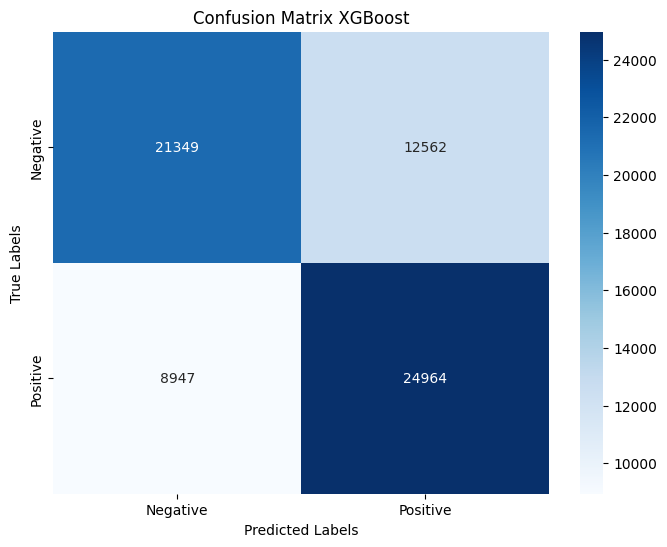

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix data (replace this with your actual cm variable)
TN_xgb = 21349
FP_xgb = 12562
FN_xgb = 8947
TP_xgb = 24964

cm = [[TN_xgb, FP_xgb], [FN_xgb, TP_xgb]]

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost')
plt.show()

# Feed Forward Neural Network

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score
from keras_tuner import HyperModel, RandomSearch

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_first', min_value=32, max_value=512, step=32), 
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(units=hp.Int('units_second', min_value=16, max_value=256, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning')

# Perform hyperparameter tuning
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.1, verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", accuracy)

# Predict probabilities on test set
y_pred_probs = best_model.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate log loss
logloss_fnn = log_loss(y_test, y_pred_probs)
print("Log Loss FNN:", logloss_fnn)

# Confusion Matrix
cm_fnn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix FNN:")
print(cm_fnn)

# Compute TPR and FPR
TN_fnn, FP_fnn, FN_fnn, TP_fnn = cm_fnn.ravel()
TPR_fnn = TP_fnn / (TP_fnn + FN_fnn)
FPR_fnn = FP_fnn / (FP_fnn + TN_fnn)
print("True Positive Rate (TPR) (FNN):", TPR_fnn)
print("False Positive Rate (FPR) (FNN):", FPR_fnn)

# Calculate F1-score
f1_fnn = f1_score(y_test, y_pred)
print("F1-score FNN:", f1_fnn)

Trial 10 Complete [00h 08m 12s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 0.6703895926475525
Total elapsed time: 01h 02m 05s
2120/2120 [==============================] - 5s 2ms/step - loss: 0.6079 - accuracy: 0.6700
Test Accuracy: 0.6699596047401428
2120/2120 [==============================] - 4s 1ms/step
Log Loss FNN: 0.6079432852531219
Confusion Matrix FNN:
[[20249 13662]
 [ 8722 25189]]
True Positive Rate (TPR) (FNN): 0.7427973224027602
False Positive Rate (FPR) (FNN): 0.40287812214325736
F1-score FNN: 0.6923668948077294


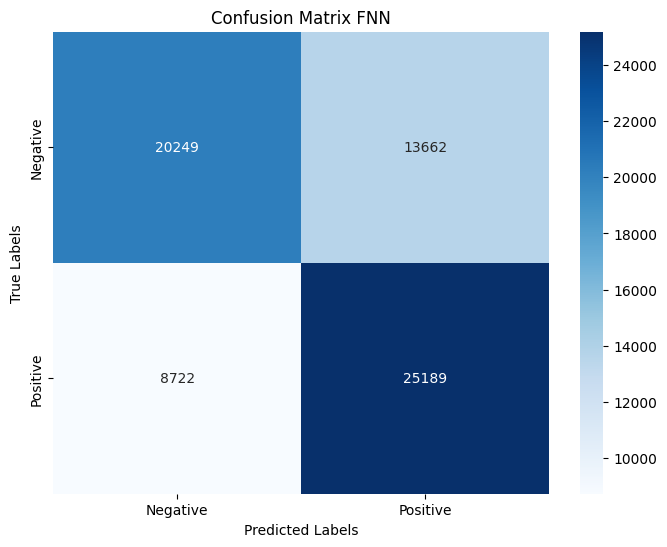

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix data (replace this with your actual cm variable)
TN_fnn = 20249
FP_fnn = 13662
FN_fnn = 8722
TP_fnn = 25189

cm = [[TN_fnn, FP_fnn], [FN_fnn, TP_fnn]]

# Labels for the classes
class_labels = ['Negative', 'Positive']

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix FNN')
plt.show()

# Feature Importance

In [1]:
import numpy as np

def calculate_feature_importance(model, X):
    """
    Calculate feature importance based on the absolute weights of the connections between
    input features and the hidden layers of the given model.

    Parameters:
    - model: Trained machine learning model (e.g., neural network)
    - X: Input features (numpy array or pandas DataFrame)

    Returns:
    - feature_importance: Dictionary containing feature names and their importance scores
    """

    # Extracting the weights of the first layer (assuming the model is sequential)
    first_layer_weights = model.layers[0].get_weights()[0]

    # Calculate the absolute sum of weights for each feature
    feature_importance_scores = np.abs(first_layer_weights).sum(axis=1)

    # Get feature names (if X is a DataFrame)
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        # Assuming feature names are not available
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # Create a dictionary to store feature importance scores
    feature_importance = dict(zip(feature_names, feature_importance_scores))

    # Sort feature importance scores in descending order
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

    return feature_importance
